**Probabilistic Seismic Hazard Analysis  
Sample Calculation In Class  
Major Zeng, University of Michigan**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

#### Method 1: Numerical Integration / Discretization

Step 1: Discretize Magnitude Range

In [ ]:
# For Fault A
# Minimum Considered Magnitude
M0 = 5 
# Maximum Considered Magnutyde
Mu = 7.5  
# Size of Magnitude Bin
del_M = 0.1
# Discretized Range of Magnitudes
Mi = np.arange(M0, Mu+del_M, del_M)

In [ ]:
Mi

Step 2: Calculate the rate of earthquakes of magnitude Mi

In [ ]:
# Occurance Model Parameterss
a = 5
b = 1
# Rate of Events with M > Upper Bound of Magnitude Bin
Lambda_u = 10**(a - b * (Mi + del_M/2))
# Rate of Events with M > Lower Bound of Magnitude Bin
Lambda_0 = 10**(a - b * (Mi - del_M/2))
# Rate of Events within the Magnitude Bin
Lambda_bin = Lambda_0 - Lambda_u

In [ ]:
Lambda_bin

Now we have a Stochastic Event Table

In [ ]:
# Create Stochastic Event Table
data = {
    "Event ID": [f"EQ{str(i+1).zfill(3)}" for i in range(len(Mi))],
    "Source": ["Fault A"] * len(Mi),
    "Size (Mw)": [f"[{M-del_M/2:.2f}, {M+del_M/2:.2f}]" for M in Mi],
    "Rate (λ)": Lambda_bin
}
df_event = pd.DataFrame(data)

# Display 
df_event

Step 3: Calculate Site Event Intensity

In [ ]:
# Function for GMPE
def GMPE_BJF97_SA1(Mag, Dis, Vs30):
    Mu_lnIM = -3.4415 + 1.42*Mag - 0.032*Mag**2 - 0.798*np.log((Dis**2+8.41)**0.5)-0.698*np.log(Vs30)
    Sigma_lnIM = 0.52
    return Mu_lnIM, Sigma_lnIM 

In [ ]:
# Distance from Source to Site
Dis = 10
# Site Soil Condition Paramter
Vs30 = 400
# Mean of IM in Log Space
Mu_lnIM = [ GMPE_BJF97_SA1(M, Dis, Vs30)[0] for M in Mi]
# Std of IM in Log Space
Sigma_lnIM = [ GMPE_BJF97_SA1(M, Dis, Vs30)[1] for M in Mi]

In [ ]:
# Create DataFrame
df = pd.DataFrame({
    'Magnitude': Mi,
    'LogMeanIM': Mu_lnIM,
    'LogStdIM': Sigma_lnIM
})
df

Step 4:

In [ ]:
# Discretize range of relevant intensity
del_IM = 0.1
Target_IM = np.arange(0.1, 3, del_IM)

In [ ]:
Target_IM

In [ ]:
# Function Calculate Probability of Exceeding 
# Given a Threshold Intensity Level, Logmean and LogStd of the Mag Distr
def Prob_exceed (Target_IM, Mu_lnIM, Sigma_lnIM):
    P_exceed = 1 - scipy.stats.norm.cdf(np.log(Target_IM[i]), 
                                        loc=Mu_lnIM, 
                                        scale=Sigma_lnIM)
    return P_exceed     

In [ ]:
# Calculate Probability of Exceedance for each IM level and each Mag level
df_ex_prob = pd.DataFrame(columns= Target_IM, index = Mi)
for i in range(len(Target_IM)):
    for j in range(len(Mi)):
        p = Prob_exceed(Target_IM,Mu_lnIM[j],Sigma_lnIM[j])
        df_ex_prob.loc[Mi[j], Target_IM[i]] = p

In [ ]:
df_ex_prob

In [ ]:
# Calculate Rate of Exceedance for each IM level and each event 
df_ex_rate = pd.DataFrame(columns=Target_IM, index=Mi)
for i in range(len(Target_IM)):
    for j in range(len(Mi)):
        prob_ex = df_ex_prob.loc[Mi[j], Target_IM[i]]
        rate = Lambda_bin[j]
        rate_ex = prob_ex * rate
        df_ex_rate.loc[Mi[j], Target_IM[i]] = rate_ex

In [ ]:
df_ex_rate

In [ ]:
# Sum to constructe the Exceedance Rate Curve
Rate_Ex_A = pd.DataFrame(df_ex_rate.sum()).T 
Rate_Ex_A.index = ["Total Exceedence Rate"]
Rate_Ex_A

In [ ]:
# Calculate Rate of Exceedance at each IM level for all magnitudes
Rate_Ex_A = df_ex_rate.sum()

In [ ]:
# Plot Exceedance Curve

plt.figure(figsize=(8, 6))
plt.loglog(Target_IM, Rate_Ex_A, label = 'Hazard due to Fault A')

plt.xlabel("SA(1s) [g]")
plt.ylabel("Exceedence Rate")
plt.title("Hazard Curve for SA(1s) Building at Site S")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 
 
plt.show()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [3]:
# Function for GMPE used
def GMPE_BJF97_SA1(Mag, Dis, Vs30):
    Mu_lnIM = -3.4415 + 1.42*Mag - 0.032*Mag**2 - 0.798*np.log((Dis**2+8.41)**0.5)-0.698*np.log(Vs30)
    Sigma_lnIM = 0.52
    return Mu_lnIM, Sigma_lnIM 

In [4]:
# Function Calculate Probability of Exceeding 
# Given a Intensity Level, a Stochastic Event and its rate of occurance
def Prob_exceed (Target_lnIM, Mu_lnIM, Sigma_lnIM):
    P_exceed = 1 - scipy.stats.norm.cdf(Target_lnIM, 
                                        loc=Mu_lnIM, 
                                        scale=Sigma_lnIM)
    return P_exceed     

In [5]:
def Func_Hazard_Curve(M0,Mu,a,b,Dis,Vs30,del_M,Target_IM):
    
    # Discretize Magnitudes
    Mi = np.arange(M0, Mu+del_M, del_M)
    
    # Rate of EQ in each magnitude bin
    Lambda = 10**(a - b * (Mi - del_M/2)) - 10**(a - b * (Mi + del_M/2))  

    # Mean of IM in Log Space
    Mu_lnIM = [ GMPE_BJF97_SA1(M, Dis, Vs30)[0] for M in Mi]
    # Std of IM in Log Space
    Sigma_lnIM = [ GMPE_BJF97_SA1(M, Dis, Vs30)[1] for M in Mi]
    
    # Log Target_IM
    Target_lnIM = np.log(Target_IM)
    
    # Compute probability of exceedance
    ex_prob_matrix = np.zeros((len(Mi), len(Target_IM)))
    for i in range(len(Target_IM)):
        for j in range(len(Mi)):
            ex_prob_matrix[j, i] = Prob_exceed(Target_lnIM[i], Mu_lnIM[j], Sigma_lnIM[j])
    
    # Compute Rate of Exceedance
    ex_rate_matrix = ex_prob_matrix*Lambda[:, np.newaxis]
    
    # Compte Rate of Exceedance from all Mags
    ex_rate= np.sum(ex_rate_matrix, axis=0)
    
    return ex_rate

In [6]:
HC_A = Func_Hazard_Curve(M0 = 5,
                         Mu = 7.5,
                         a = 5,
                         b = 1,
                         Dis = 10,
                         Vs30 = 400,
                         del_M = 0.01,
                         Target_IM = np.arange(0.1, 3, 0.1))

HC_B = Func_Hazard_Curve(M0 = 5,
                         Mu = 8.5,
                         a = 4,
                         b = 0.9,
                         Dis = 20,
                         Vs30 = 400,
                         del_M = 0.01,
                         Target_IM = np.arange(0.1, 3, 0.1))

In [7]:
index_names = ['Exceed Rate Fault A', 'Exceed Rate Fault B','Exceed Rate Total']
# Define data as NumPy arrays
row_1 = HC_A
row_2 = HC_B
row_3 = HC_A + HC_B
# Create DataFrame
df = pd.DataFrame([row_1, row_2, row_3], columns=np.arange(0.1, 3, 0.1), index=index_names)
df

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,...,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9
Exceed Rate Fault A,0.241174,0.057309,0.021567,0.010017,0.005200,0.002891,0.001685,0.001018,0.000633,0.000403,...,0.000010,0.000007,0.000005,0.000004,0.000003,0.000002,0.000002,0.000001,1.030247e-06,7.953720e-07
Exceed Rate Fault B,0.032629,0.007962,0.003287,0.001683,0.000965,0.000592,0.000380,0.000252,0.000172,0.000119,...,0.000006,0.000005,0.000004,0.000003,0.000002,0.000002,0.000001,0.000001,8.821605e-07,7.096902e-07
Exceed Rate Total,0.273803,0.065270,0.024855,0.011700,0.006165,0.003483,0.002066,0.001271,0.000805,0.000522,...,0.000016,0.000012,0.000009,0.000007,0.000005,0.000004,0.000003,0.000002,1.912408e-06,1.505062e-06


In [ ]:
# Plot Exceedance Curve

plt.figure(figsize=(8, 6))
Target_IM = np.arange(0.1, 3, 0.1)
plt.loglog(Target_IM, HC_A, label = 'Hazard Due to Fault A',linewidth=1)
plt.loglog(Target_IM, HC_B, label = 'Hazard Due to Fault B',linewidth=1)
plt.loglog(Target_IM, HC_A+HC_B, label = 'Total Hazard', linewidth=2)

plt.xlabel("SA(1s) [g]")
plt.ylabel("Exceedence Rate")
plt.title("Hazard Curve for SA(1s) Building at Site S")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Both major and minor grid
 
plt.show()

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [ ]:
# Define integration limits for M
m_limits = {
    'A': (5, 7.5),  
    'B': (5, 8.5)  
}

# Define constant R value
r_values = {
    'A': 10,  
    'B': 20}   

# Define set of sources and their parameterstheir occurrence rates
sources = ['A', 
           'B'] 
source_para = {"A":{'a':5,'b':1},
               "B":{'a':4,'b':0.9}}

In [ ]:
# Define Occurance Rate for Sources
def Lambda(s):
    
    a = source_para[s]['a']
    alpha = a*np.log(10)
    b = source_para[s]['b']
    beta = b*np.log(10)
    
    M0 = m_limits[s][0]
    Mu = m_limits[s][1]
    
    total_rate = (np.exp(alpha - beta * M0) - np.exp(alpha - beta * Mu)) / beta
    return total_rate

In [ ]:
# Define PDF for Magnitude Occurance
def f_M(m, s):
    """ Probability density function f_M(m | s) """
    
    a = source_para[s]['a']
    alpha = a*np.log(10)
    b = source_para[s]['b']
    beta = b*np.log(10)
    
    M0 = m_limits[s][0]
    Mu = m_limits[s][1]
    
    f_m = beta * np.exp(-beta * (m - M0)) / ( 1 - np.exp(-beta * (Mu - M0)))
    return f_m

In [ ]:
# Define Probability Functions
def P_IM(im, r, m, s):
    """ Probability function P(IM > im | r, m, s) """
    
    # GMPE Function
    def GMPE_BJF97_SA1(Mag, Dis, Vs30):
        Mu_lnIM = -3.4415 + 1.42*Mag - 0.032*Mag**2 - 0.798*np.log((Dis**2+8.41)**0.5)-0.698*np.log(Vs30)
        Sigma_lnIM = 0.52
        return Mu_lnIM, Sigma_lnIM 
    
    # Run GMPE
    Mu_lnIM, Sigma_lnIM = GMPE_BJF97_SA1(m, r, 400)
    
    # Probability of Exceeding a given im threshold
    P_exceed = 1 - sp.stats.norm.cdf(np.log(im), loc=Mu_lnIM, scale=Sigma_lnIM)
    
    return P_exceed 

In [ ]:
def lambda_exceedance(im):
    """
    Computes λ(IM > im) for a given im threshold
    """
    return sum(
        Lambda(s) * sp.integrate.quad(
            lambda m: P_IM(im, r_values[s], m, s) * f_M(m, s),
            m_limits[s][0], m_limits[s][1]  # Limits for M
        )[0]
        for s in sources
    )

In [ ]:
# Calculate Exceedance Rate for All IM levels
im_values = np.arange(0.1, 3, 0.1) 
Rate_Ex_Int = []
for im in im_values:
    Rate_Ex_Int.append(lambda_exceedance(im))

In [ ]:
# Plot Exceedance Curve

plt.figure(figsize=(8, 6))
Target_IM = np.arange(0.1, 3, 0.1)
plt.loglog(Target_IM, HC_A+HC_B, label = 'Discritization', linewidth=2)
plt.loglog(Target_IM, Rate_Ex_Int, label = 'Integration', linewidth=2)

plt.xlabel("SA(1s) [g]")
plt.ylabel("Exceedence Rate")
plt.title("Hazard Curve for 1s Building at Site S")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Both major and minor grid
 
plt.show()

#### Method 2: Monte Carlo Simulation

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Monte Carlo Events Simulation**

In [22]:
def Func_MC_Event_Sim(M0, Mu, del_M, a, b, T, Source):
    
    # Magnitude Levels
    Mi = np.arange(M0, Mu, del_M)
    # Rate of Occurance for Each Magnitudes
    Lambda = 10**(a - b * (Mi - del_M/2)) - 10**(a - b * (Mi + del_M/2)) 
    
    # Simulation Table
    Events = []
    
    # For each Magnitude Level
    for i in range(len(Mi)):
        # Magnitude
        m = Mi[i]
        # Generate Events in Each Year
        Ns = np.random.poisson(Lambda[i],T)
        # For each Year
        for i in range(T):
            # Year
            t = i
            # Number of Events for this Magnitude
            n = Ns[i]
            # Store Events in Event Table
            for _ in range(n): 
                Events.append([t, Source, m])
                
    # Create DataFrame
    df_result = pd.DataFrame(Events, columns=["Year", "Source", "Magnitude"])

    return df_result

In [23]:
# Simulated Events for Each Fault for 1000 Years
Sim_Events_A = Func_MC_Event_Sim(M0=5, Mu=7.5, del_M=0.1, a=5, b=1, T=25000, Source='Fault A')
Sim_Events_B = Func_MC_Event_Sim(M0=5, Mu=8.5, del_M=0.1, a=4, b=0.9, T=25000, Source='Fault B')

# Combine Simulated Event Table
Sim_Events = pd.concat([Sim_Events_A, Sim_Events_B], ignore_index=True)

# Sort by "Year" column in ascending order
Sim_Events = Sim_Events.sort_values(by="Year", ascending=True).reset_index(drop=True)

In [24]:
Sim_Events

,Year,Source,Magnitude
0,0,Fault A,5.6
1,1,Fault A,5.1
2,1,Fault B,5.0
3,1,Fault B,5.0
4,2,Fault A,5.0
...,...,...,...
36894,24994,Fault A,5.1
36895,24996,Fault A,5.6
36896,24996,Fault A,5.4
36897,24997,Fault A,5.2


**Intensity Calculation for Each Event**

In [25]:
# GMPE Function
def GMPE_BJF97_SA1(Mag, Dis, Vs30):
    Mu_lnIM = -3.4415 + 1.42*Mag - 0.032*Mag**2 - 0.798*np.log((Dis**2+8.41)**0.5)-0.698*np.log(Vs30)
    Sigma_lnIM = 0.52
    return Mu_lnIM, Sigma_lnIM 

In [26]:
# Parameterss
Dis = {'Fault A':10, 'Fault B':20}
# 
Sim_IM = []

# For each event, simulate a IM
for _, row in Sim_Events.iterrows():
    
    # Magnitude and Distance for this Event
    M = row['Magnitude']
    D = Dis[row['Source']]
    
    # Log Mean and Std of IM for this event
    Mu_lnIM, Sigma_lnIM = GMPE_BJF97_SA1(M, D, 400)

    # Simulate a IM
    im = np.random.lognormal(mean=Mu_lnIM, sigma=Sigma_lnIM)
    Sim_IM.append(im)

# Add to Simulation Event Table
Sim_Events['SA(1s)'] = Sim_IM

In [27]:
Sim_Events

,Year,Source,Magnitude,SA(1s)
0,0,Fault A,5.6,0.046887
1,1,Fault A,5.1,0.042335
2,1,Fault B,5.0,0.022260
3,1,Fault B,5.0,0.032323
4,2,Fault A,5.0,0.015389
...,...,...,...,...
36894,24994,Fault A,5.1,0.029519
36895,24996,Fault A,5.6,0.051026
36896,24996,Fault A,5.4,0.100240
36897,24997,Fault A,5.2,0.041167


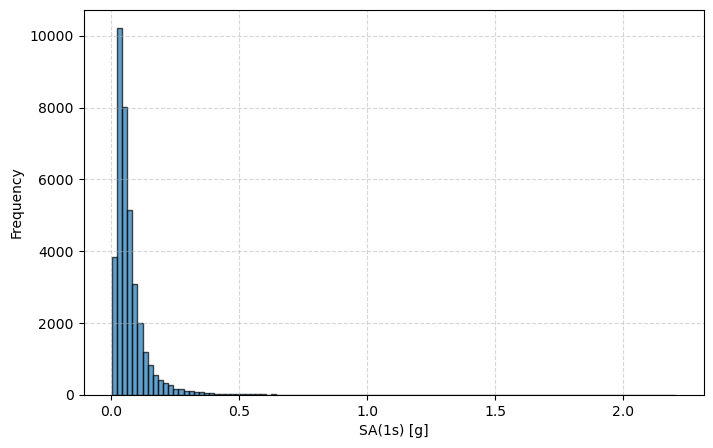

In [28]:
def plot_histogram(data, bin_size):
    
    # Compute min & max values for bin range
    data_min, data_max = min(data), max(data)
    
    # Generate bin edges based on bin size
    bins = np.arange(data_min, data_max + bin_size, bin_size)
    
    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.7)

    # Labels and title
    plt.xlabel("SA(1s) [g]")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Show the histogram
    plt.show()

plot_histogram(Sim_Events['SA(1s)'], 0.02)

**Hazard Curve Construction**

In [29]:
def Sim_Rate_Ex(SimIM, TargetIM, T):

    ex_rates = []
    
    # For each IM threshold
    for im in TargetIM:
        
        # Count the number of simulated IM > threshold
        count_ex = np.sum(np.array(SimIM) > im)  
        
        # Calculate Rate = Counte / Years
        rate = count_ex / T  
        
        ex_rates.append(rate)
    
    df_result = pd.DataFrame({'IM': TargetIM, 'Exceedance_Rate': ex_rates})
    
    return df_result

In [30]:
Rate_Ex_Sim = Sim_Rate_Ex(SimIM = Sim_Events['SA(1s)'], 
                          TargetIM = np.arange(0.1,3,0.1), 
                          T=25000)

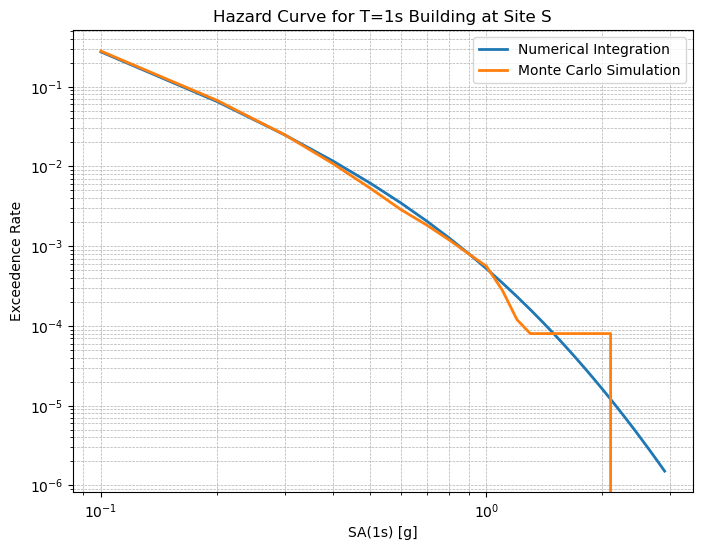

In [32]:
# Plot Exceedance Curve

plt.figure(figsize=(8, 6))
Target_IM = np.arange(0.1, 3, 0.1)
plt.loglog(Target_IM, HC_A+HC_B, label = 'Numerical Integration', linewidth=2)
plt.loglog(Target_IM, Rate_Ex_Sim['Exceedance_Rate'], label = 'Monte Carlo Simulation', linewidth=2)

plt.xlabel("SA(1s) [g]")
plt.ylabel("Exceedence Rate")
plt.title("Hazard Curve for T=1s Building at Site S")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Both major and minor grid
 
plt.show()